In [1]:
"""
Title: Keypoint Detection with Transfer Learning
Author: [Sayak Paul](https://twitter.com/RisingSayak)
Date created: 2021/05/02
Last modified: 2021/05/02
Description: Training a keypoint detector with data augmentation and transfer learning.
"""
"""
Keypoint detection consists of locating key object parts. For example, the key parts
of our faces include nose tips, eyebrows, eye corners, and so on. These parts help to
represent the underlying object in a feature-rich manner. Keypoint detection has
applications that include pose estimation, face detection, etc.
In this example, we will build a keypoint detector using the
[StanfordExtra dataset](https://github.com/benjiebob/StanfordExtra),
using transfer learning. This example requires TensorFlow 2.4 or higher,
as well as [`imgaug`](https://imgaug.readthedocs.io/) library,
which can be installed using the following command:
"""

"""shell
pip install -q -U imgaug
"""

"""
## Data collection
"""

"""
The StanfordExtra dataset contains 12,000 images of dogs together with keypoints and
segmentation maps. It is developed from the [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).
It can be downloaded with the command below:
"""

"""shell
wget -q http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
"""

"""
Annotations are provided as a single JSON file in the StanfordExtra dataset and one needs
to fill [this form](https://forms.gle/sRtbicgxsWvRtRmUA) to get access to it. The
authors explicitly instruct users not to share the JSON file, and this example respects this wish:
you should obtain the JSON file yourself.
The JSON file is expected to be locally available as `stanfordextra_v12.zip`.
After the files are downloaded, we can extract the archives.
"""

"""shell
tar xf images.tar
unzip -qq ~/stanfordextra_v12.zip
"""

"""
## Imports
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
"""
## Define hyperparameters
"""

IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 200
NUM_KEYPOINTS = 8 # 9 keypoints each having x and y coordinates

In [3]:
"""
## Load data
The authors also provide a metadata file that specifies additional information about the
keypoints, like color information, animal pose name, etc. We will load this file in a `pandas`
dataframe to extract information for visualization purposes.
"""

IMG_DIR = "/home/tim/BT_Vision/convert_to_coco/test_dataset_coco/images/train"
IMG_DIR_VAL = "/home/tim/BT_Vision/convert_to_coco/test_dataset_coco/images/val"
JSON = "/home/tim/BT_Vision/convert_to_coco/test_dataset_coco/annotations/pole_keypoints_8_train.json"
JSON_VAL = "/home/tim/BT_Vision/convert_to_coco/test_dataset_coco/annotations/pole_keypoints_8_val.json"
KEYPOINT_DEF = (
    "keypoint_definitions.csv"
)

# Load the ground-truth annotations.
with open(JSON) as infile:
    coco_data = json.load(infile)

with open(JSON_VAL) as infile:
    coco_data_val = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.

def coco_to_json_data(coco_data, IMG_DIR):
    coco_annotations = coco_data["annotations"]
    coco_images = coco_data["images"]
    json_data = []
    for entry in coco_annotations:
        img_bbox = entry["bbox"]
        joints = []
        for i in range(NUM_KEYPOINTS):
            joints.append([entry["keypoints"][3*i],entry["keypoints"][3*i+1],entry["keypoints"][3*i+2]])
        for img in coco_images:
            if img["id"] == entry["image_id"]:
                image_name = img["file_name"]
                image_path = os.path.join(IMG_DIR, image_name)
                img_width = img["width"]
                img_height = img["height"]
        json_data_entry = {
            "img_bbox": img_bbox,
            "img_height": img_height,
            "img_width": img_width,
            "img_path": image_path,
            "joints": joints,
        }
        json_data.append(json_data_entry)
    json_dict = {i["img_path"]: i for i in json_data}
    return json_data, json_dict


json_data, json_dict = coco_to_json_data(coco_data, IMG_DIR)
json_data_val, json_dict_val = coco_to_json_data(coco_data_val, IMG_DIR_VAL)

A single entry of `json_dict` looks like the following:
```
'n02085782-Japanese_spaniel/n02085782_2886.jpg':
{'img_bbox': [205, 20, 116, 201],
 'img_height': 272,
 'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
            [147.66666666666666, 229.0, 1],
            [163.5, 208.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [54.0, 244.0, 1],
            [77.33333333333333, 225.33333333333334, 1],
            [79.0, 196.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [150.66666666666666, 86.66666666666667, 1],
            [88.66666666666667, 73.0, 1],
            [116.0, 106.33333333333333, 1],
            [109.0, 123.33333333333333, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
 'seg': ...}
```
"""

"""
In this example, the keys we are interested in are:
* `img_path`
* `joints`
There are a total of NUM_KEYPOINTS entries present inside `joints`. Each entry has 3 values:
* x-coordinate
* y-coordinate
* visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility)
As we can see `joints` contain multiple `[0, 0, 0]` entries which denote that those
keypoints were not labeled. In this example, we will consider both non-visible as well as
unlabeled keypoints in order to allow mini-batch learning.

In [4]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex_colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

# Utility for reading an image and for getting its annotations.

def get_pole(name):
    for i in json_dict.keys():
        if i == name:
            data = json_dict[name]
    for i in json_dict_val.keys():
        if i == name:
            data = json_dict_val[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_path"]))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

# Extract the colours and labels.
colours = keypoint_def["Hex_colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

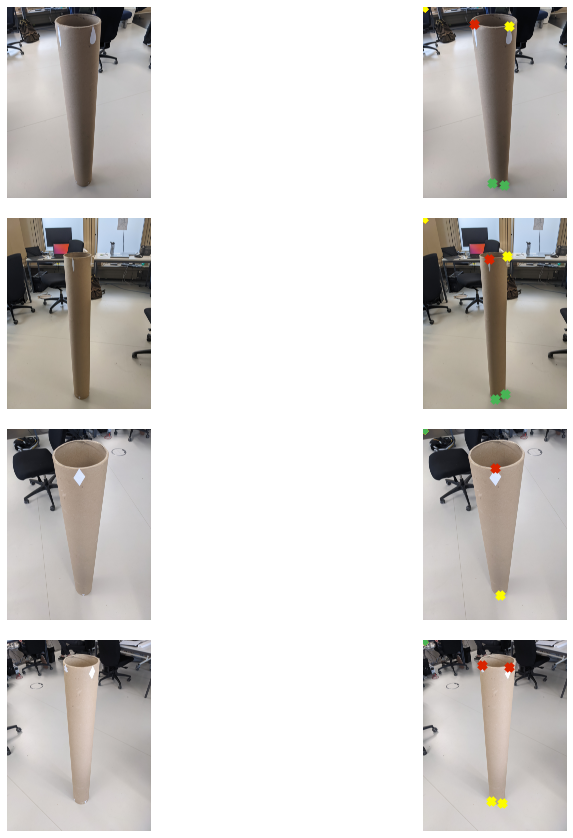

In [13]:
"""
## Visualize data
Now, we write a utility function to visualize the images and their keypoints.
"""

# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
samples_val = list(json_dict_val.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_pole(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)


In [5]:
"""
## Prepare data generator
"""

class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS*2), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_pole(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[
                i,
            ] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(
                kp_temp
            ).reshape(1, 1, NUM_KEYPOINTS * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

# doc keypoints in imgaug: [this document](https://imgaug.readthedocs.io/en/latest/source/examples_keypoints.html).


In [6]:
"""
## Define augmentation transforms
"""

train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [14]:
"""
## Create training and validation splits
"""

np.random.shuffle(samples)
np.random.shuffle(samples_val)

train_keys = samples
validation_keys = samples_val

In [20]:
"""
## Data generator investigation
"""

train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:2].reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE
visualize_keypoints(sample_images[:2], sample_keypoints)

Total batches in training set: 3
Total batches in validation set: 1


AssertionError: 

In [16]:
"""
## Model building
The [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) (on which
the StanfordExtra dataset is based) was built using the [ImageNet-1k dataset](http://image-net.org/).
So, it is likely that the models pretrained on the ImageNet-1k dataset would be useful
for this task. We will use a MobileNetV2 pre-trained on this dataset as a backbone to
extract meaningful features from the images and then pass those to a custom regression
head for predicting coordinates.
"""


def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS*2, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS*2, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [17]:
"""
Our custom network is fully-convolutional which makes it more parameter-friendly than the
same version of the network having fully-connected dense layers.
"""

get_model().summary()

2022-06-02 09:42:55.516776: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 09:42:55.516845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tim-XPS-15-9550): /proc/driver/nvidia/version does not exist
2022-06-02 09:42:55.519210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

In [18]:
"""
Notice the output shape of the network: `(None, 1, 1, NUM_KEYPOINTS*2)`. This is why we have reshaped
the coordinates as: `batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, NUM_KEYPOINTS * 2)`.
"""

"""
## Model compilation and training
For this example, we will train the network only for five epochs.
"""

model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-3), metrics=["accuracy"])
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS, batch_size=2)

Epoch 1/200
3/3 [==============================] - 6s 1s/step - loss: 0.1370 - accuracy: 0.0833 - val_loss: 0.1992 - val_accuracy: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 2s 913ms/step - loss: 0.1387 - accuracy: 0.3333 - val_loss: 0.1930 - val_accuracy: 0.0000e+00
Epoch 3/200
3/3 [==============================] - 2s 846ms/step - loss: 0.1462 - accuracy: 0.4167 - val_loss: 0.1855 - val_accuracy: 0.0000e+00
Epoch 4/200
3/3 [==============================] - 2s 740ms/step - loss: 0.1399 - accuracy: 0.2500 - val_loss: 0.1763 - val_accuracy: 0.0000e+00
Epoch 5/200
3/3 [==============================] - 2s 763ms/step - loss: 0.1474 - accuracy: 0.0833 - val_loss: 0.1658 - val_accuracy: 0.0000e+00
Epoch 6/200
3/3 [==============================] - 2s 860ms/step - loss: 0.0991 - accuracy: 0.0000e+00 - val_loss: 0.1536 - val_accuracy: 0.0000e+00
Epoch 7/200
3/3 [==============================] - 2s 796ms/step - loss: 0.1512 - accuracy: 0.5000 - val_loss: 0.1449 - val_accur

In [21]:
#Save Model in Network folder
model.save("network")

INFO:tensorflow:Assets written to: network/assets


INFO:tensorflow:Assets written to: network/assets


1/1 [==============================] - 1s 734ms/step


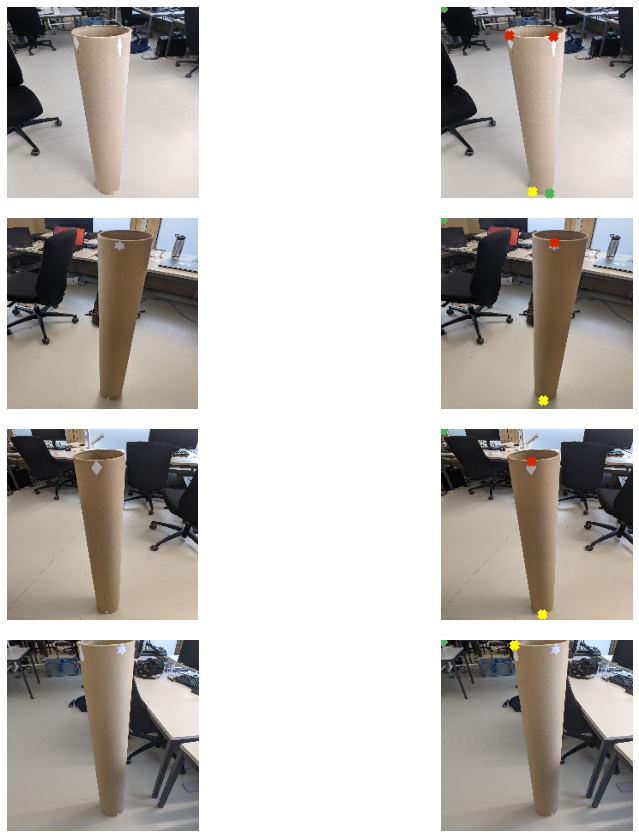

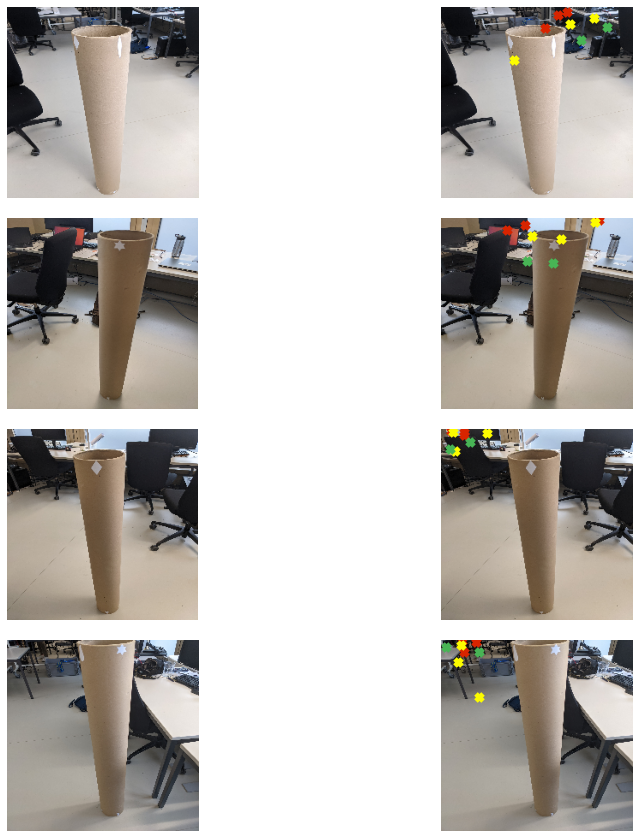

'\n## Going further\n* Try using other augmentation transforms from `imgaug` to investigate how that changes\nthe results.\n* Here, we transferred the features from the pre-trained network linearly that is we did\nnot [fine-tune](https://keras.io/guides/transfer_learning/) it. You are encouraged to fine-tune it on this task and see if that\nimproves the performance. You can also try different architectures and see how they\naffect the final performance.\n'

In [19]:
"""
## Make predictions and visualize them
"""
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

"""
Predictions will likely improve with more training.
"""

"""
## Going further
* Try using other augmentation transforms from `imgaug` to investigate how that changes
the results.
* Here, we transferred the features from the pre-trained network linearly that is we did
not [fine-tune](https://keras.io/guides/transfer_learning/) it. You are encouraged to fine-tune it on this task and see if that
improves the performance. You can also try different architectures and see how they
affect the final performance.
"""

1/1 [==============================] - 0s 170ms/step


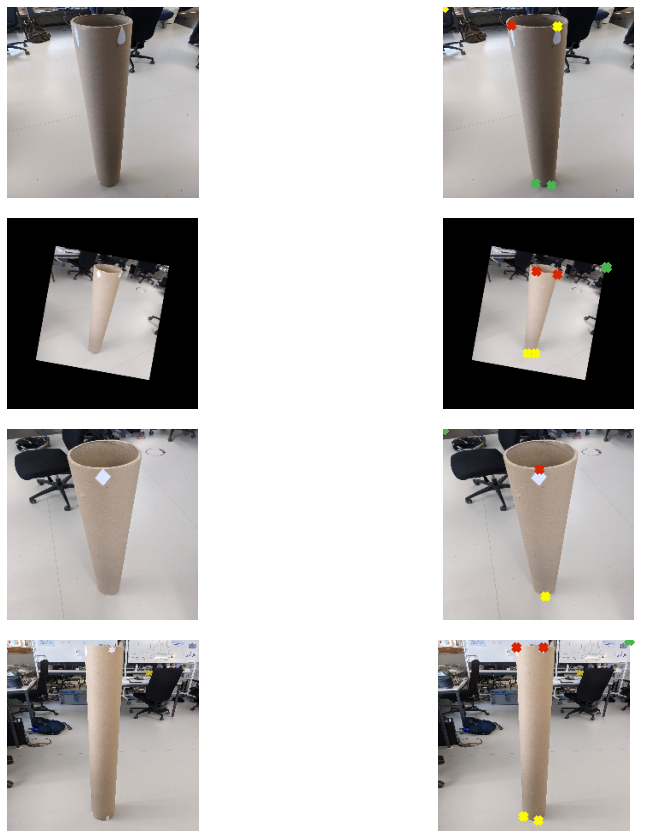

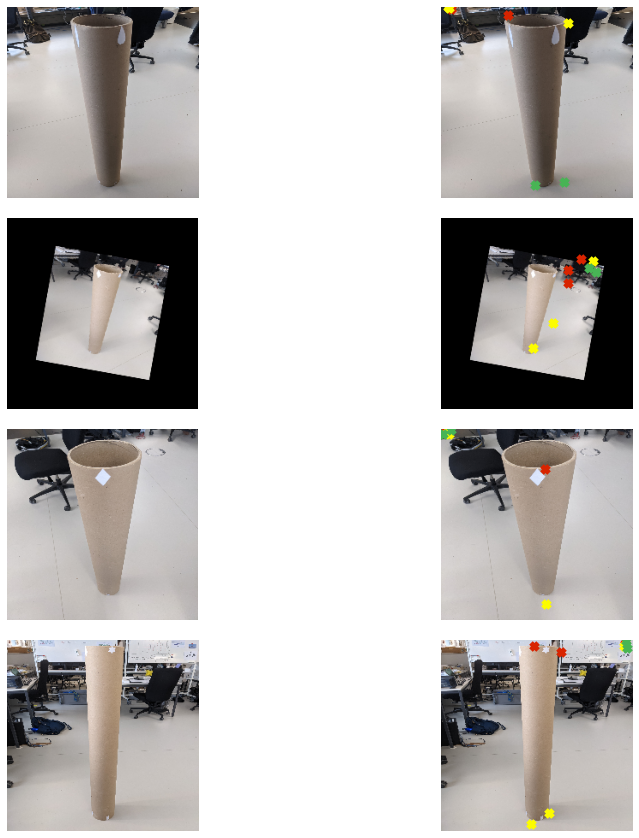

In [30]:
sample_val_images, sample_val_keypoints = next(iter(train_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE
raw_predicitions = model.predict(sample_val_images)
predictions = raw_predicitions.reshape(-1, NUM_KEYPOINTS, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)